## Importando Bibliotecas ##

In [1]:
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import seaborn as sns

sys.path.append(os.path.abspath(os.path.join(os.path.dirname('.'), '..')))

In [2]:
from data.generate_data import generate

## Adquirindo os Dados ##

### Através do Scrapping no site da Defesa Civíl de Rio do Sul e da API Open-Meteo foram adquiridos os dados relacionados as enchentes a partir de 2019-01-01 até 2024-12-31 ###

In [3]:
# train_df = generate(
#     start_date="2019-01-01",
#     end_date="2024-12-31",
#     type="train",
#     save=False
# )

train_df = pd.read_csv("train_df_2019_2024.csv")
train_df['time'] = pd.to_datetime(train_df['time'])

In [4]:
train_df.head()

,time,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation_probability,precipitation,rain,snowfall,showers,...,wind_gusts_10m_lag_16h,wind_gusts_10m_lag_17h,wind_gusts_10m_lag_18h,wind_gusts_10m_lag_19h,wind_gusts_10m_lag_20h,water_level_next_1h,water_level_next_3h,water_level_next_6h,water_level_next_12h,water_level_next_24h
0,2019-01-02 22:00:00,26.4,88,24.2,31.8,NaN,0.0,0.0,0.0,0.0,...,50.4,40.0,27.4,23.0,18.7,1.08,1.09,1.08,1.04,0.97
1,2019-01-02 23:00:00,25.6,91,24.0,30.6,NaN,0.0,0.0,0.0,0.0,...,40.0,27.4,23.0,18.7,18.0,1.08,1.08,1.08,1.04,1.02
2,2019-01-03 00:00:00,24.5,96,23.9,29.8,NaN,0.0,0.0,0.0,0.0,...,27.4,23.0,18.7,18.0,12.6,1.09,1.10,1.09,1.01,1.02
3,2019-01-03 01:00:00,24.3,97,23.8,29.7,NaN,0.0,0.0,0.0,0.0,...,23.0,18.7,18.0,12.6,9.7,1.08,1.08,1.08,1.02,1.01
4,2019-01-03 02:00:00,24.1,98,23.8,29.6,NaN,0.0,0.0,0.0,0.0,...,18.7,18.0,12.6,9.7,10.1,1.10,1.08,1.07,0.99,1.01


## EDA ##
### 1. Através da média do nível do rio de cada mês desde 2019 até 2024, foi possível se analisar através de gráficos de barra quais foram os mêses que mais houveram um nível alto do rio ###

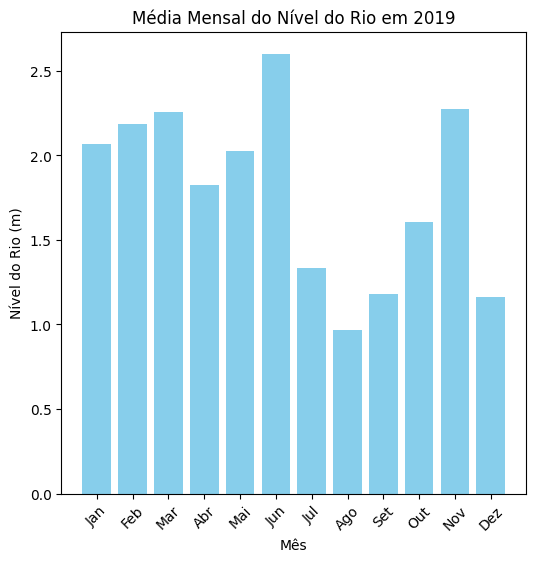

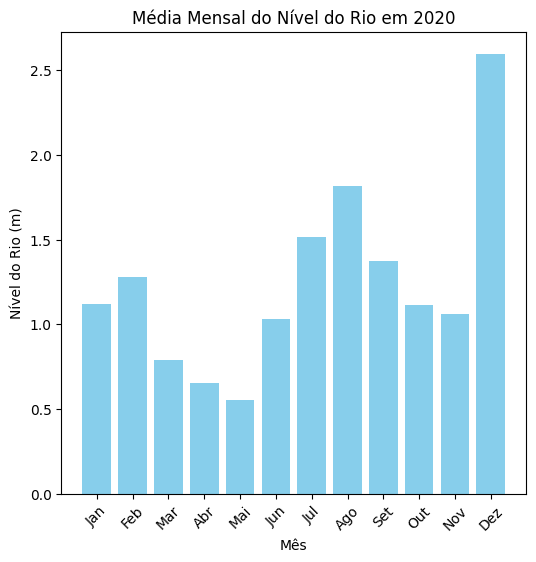

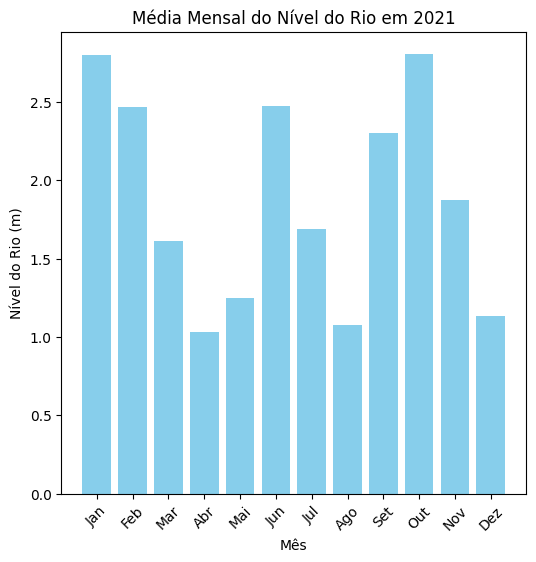

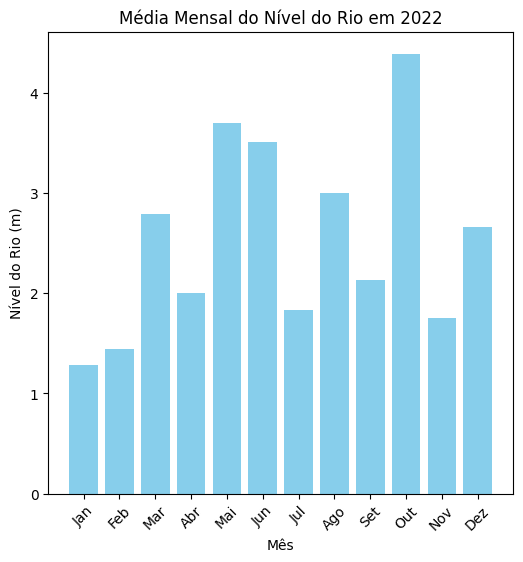

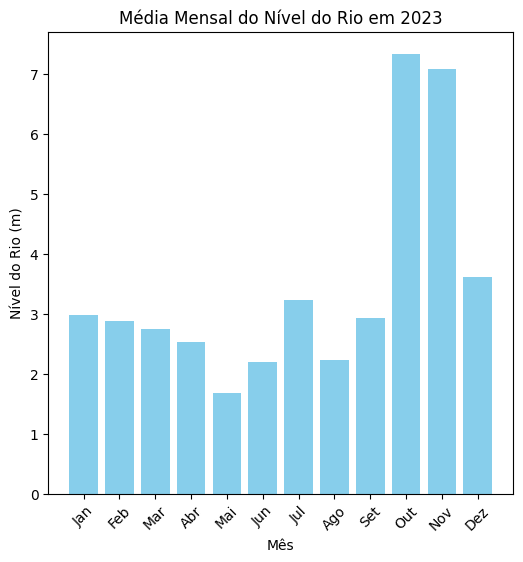

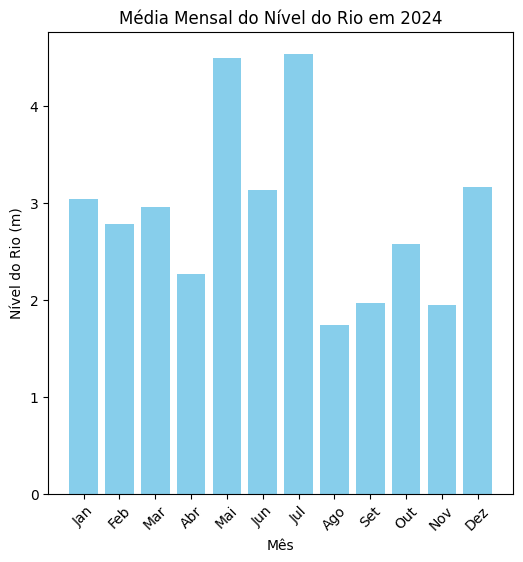

In [5]:
def month_set(ano):
    year_df = train_df[train_df['time'].dt.year == ano].copy()
    year_df['mes'] = year_df['time'].dt.month
    media_ano = year_df.groupby('mes')['water_level'].mean().reset_index()
    return media_ano

def plot_month(ano, media_ano):
    plt.bar(media_ano['mes'], media_ano['water_level'], color='skyblue')
    plt.xlabel('Mês')
    plt.ylabel('Nível do Rio (m)')
    plt.title(f'Média Mensal do Nível do Rio em {ano}')
    plt.xticks(media_ano['mes'], 
               ['Jan', 'Feb', 'Mar', 'Abr', 'Mai', 'Jun', 
                'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'])
    plt.xticks(rotation=45)
    plt.gcf().set_size_inches(6, 6)
    plt.show()

def loop_func(ano_inicial):
    if ano_inicial == 2019:
        while ano_inicial <= 2024:
            media = month_set(ano_inicial)
            plot_month(ano_inicial, media)
            ano_inicial += 1
    else:
        print("Erro: ano inicial deve ser 2019")
loop_func(2019)

### 2. Após descobrir os mêses que mais houveram um número maior na média do nível do rio, foi necessário analisar tais mêses para descobrir as features que influenciavam o aumento do nível do rio ###
exemplo:

In [6]:
month_df = train_df[train_df['time'].dt.year == 2023]
month_df['mes'] = month_df['time'].dt.month
month_df = month_df.loc[month_df['mes'] == 10]
month_df['dia'] = month_df['time'].dt.day
day_df = month_df.groupby('dia')['water_level'].mean().reset_index()
#mean_month = month_df.groupby('mes')['water_level'].mean().reset_index()
day_df

/var/folders/gr/gthl841n3w12njgwf034zxh40000gn/T/ipykernel_92505/1415852259.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  month_df['mes'] = month_df['time'].dt.month


,dia,water_level
0,1,4.055833
1,2,4.231250
2,3,3.728333
3,4,5.586667
4,5,7.849167
5,6,6.996250
6,7,7.842083
7,8,9.907292
8,9,10.775000
9,10,10.532917


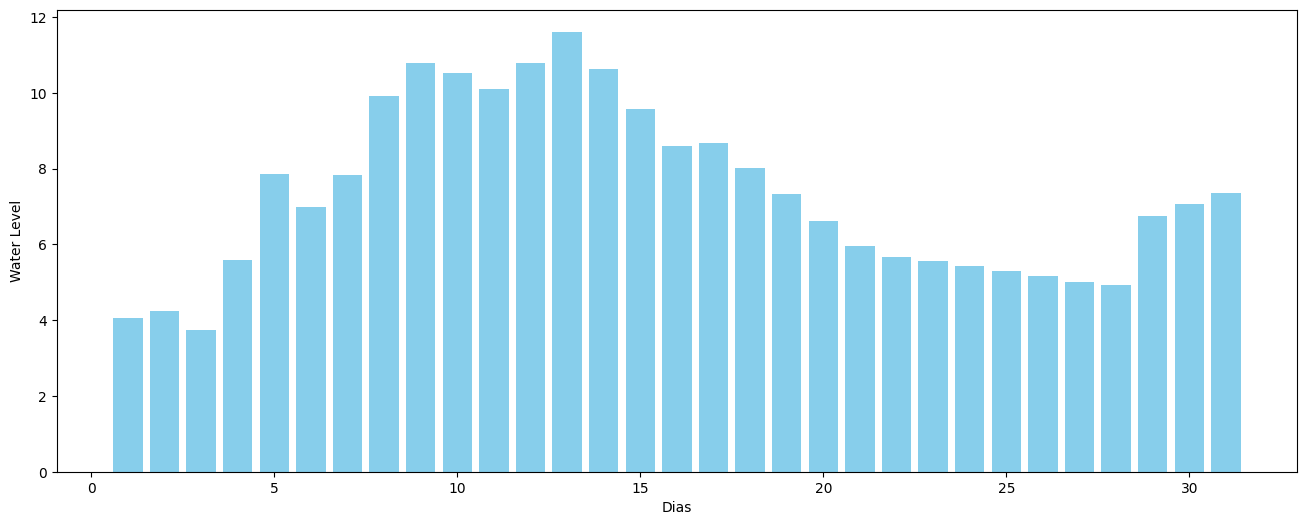

In [7]:
plt.bar(day_df['dia'], day_df['water_level'], color='skyblue')
plt.ylabel('Water Level')
plt.xlabel('Dias')
plt.gcf().set_size_inches(16, 6)
plt.show()

In [8]:
month_df.loc[month_df['time'].isin(['2023-10-01', '2023-10-02', '2023-10-03', '2023-10-04', '2023-10-05', '2023-10-06', '2023-10-07', '2023-10-08', '2023-10-09', '2023-10-10', '2023-10-11', '2023-10-12', '2023-10-13', '2023-10-14', '2023-10-15', '2023-10-16', '2023-10-17', '2023-10-18', '2023-10-19', '2023-10-20', '2023-10-21', '2023-10-22', '2023-10-23', '2023-10-24', '2023-10-25', '2023-10-26', '2023-10-27', '2023-10-28', '2023-10-29'])]

,time,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation_probability,precipitation,rain,snowfall,showers,...,wind_gusts_10m_lag_18h,wind_gusts_10m_lag_19h,wind_gusts_10m_lag_20h,water_level_next_1h,water_level_next_3h,water_level_next_6h,water_level_next_12h,water_level_next_24h,mes,dia
41570,2023-10-01,18.0,100,18.0,19.8,NaN,0.4,0.4,0.0,0.0,...,32.8,27.7,26.6,4.00,4.040000,4.050000,3.980,4.26,10,1
41594,2023-10-02,16.1,85,13.6,15.6,NaN,0.0,0.0,0.0,0.0,...,42.1,29.5,27.4,4.26,4.254545,4.246364,4.230,4.20,10,2
41618,2023-10-03,14.2,75,9.8,13.1,NaN,0.0,0.0,0.0,0.0,...,25.6,26.6,31.3,4.19,4.150000,4.070000,3.770,2.95,10,3
41642,2023-10-04,17.1,89,15.4,18.3,NaN,0.0,0.0,0.0,0.0,...,9.7,7.2,4.3,2.91,2.830000,3.030000,6.100,8.29,10,4
41666,2023-10-05,17.2,100,17.2,19.0,NaN,0.0,0.0,0.0,0.0,...,34.6,34.6,37.1,8.29,8.206364,8.080909,7.830,7.37,10,5
41690,2023-10-06,15.8,90,14.1,16.4,NaN,0.0,0.0,0.0,0.0,...,19.1,22.7,23.4,7.34,7.270000,7.190000,6.920,6.63,10,6
41714,2023-10-07,18.7,97,18.2,21.3,NaN,1.0,1.0,0.0,0.0,...,16.9,14.8,12.2,6.62,6.580000,6.540000,7.790,9.50,10,7
41738,2023-10-08,18.1,98,17.7,20.3,NaN,0.1,0.1,0.0,0.0,...,21.6,11.2,6.8,9.50,9.577273,9.693182,9.925,10.35,10,8
41762,2023-10-09,15.8,100,15.7,17.1,NaN,0.0,0.0,0.0,0.0,...,26.3,23.4,20.9,10.43,10.580000,10.750000,10.890,10.82,10,9
41786,2023-10-10,16.9,89,15.1,17.1,NaN,0.0,0.0,0.0,0.0,...,22.3,34.6,36.0,10.80,10.760000,10.690000,10.510,10.29,10,10


### 3. Assim como nos outras situações de enchentes analisadas, foi encontrado os seguintes padrões: ###
#### a) temperature_2m = variando entre 13°C a 23.1°C (mais comum ser 19°C) ou 6.2°C a 15.9°C ####
#### b) relative_humidity_2m = variando entre 88% a 100% ou 75% a 100%, sendo +90% quase certeza a vinda de uma chuva ####
#### c) rain = variando entre 1.0mm a 4.1mm, geralmente havendo uma constância/"acûmulo" em 0.X ####
#### *d) rain_24h = variando entre 12.5mm a 64.6mm, representando que quanto maior for o seu valor, maior será magnificiência da enchente, ou seja, maior o valor no nível do rio ####

### 4. Correlação ###
#### Para que seja possível aprimorar ainda mais o resultado da previsão foi feito um estudo das correlações ####

In [9]:
features = month_df.loc[:, ['temperature_2m', 'relative_humidity_2m', 'apparent_temperature', 'water_level_next_3h', 'water_level_next_24h', 'water_level_next_6h']]
features_df = pd.DataFrame(data=features)
features_df.corr()

,temperature_2m,relative_humidity_2m,apparent_temperature,water_level_next_3h,water_level_next_24h,water_level_next_6h
temperature_2m,1.000000,-0.549074,0.970498,-0.232308,-0.165852,-0.226376
relative_humidity_2m,-0.549074,1.000000,-0.380238,0.151534,0.242242,0.174190
apparent_temperature,0.970498,-0.380238,1.000000,-0.221597,-0.129162,-0.209380
water_level_next_3h,-0.232308,0.151534,-0.221597,1.000000,0.877482,0.994864
water_level_next_24h,-0.165852,0.242242,-0.129162,0.877482,1.000000,0.897005
water_level_next_6h,-0.226376,0.174190,-0.209380,0.994864,0.897005,1.000000


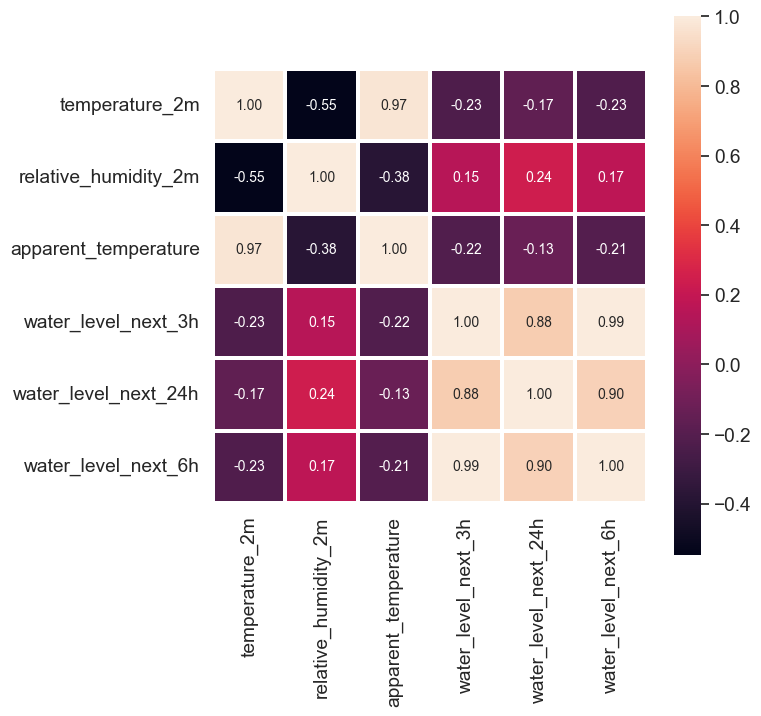

In [10]:
plt.figure(figsize=(7, 7))
sns.set(font_scale=1.25)
sns.heatmap(features_df.corr(), linewidths=1.5, annot=True, square=True, 
                fmt='.2f', annot_kws={'size': 10}, 
                yticklabels=features_df.columns , xticklabels=features_df.columns
            )
plt.show()

## Treinando com PyCaret
TODO: Documentar o que é o pycaret

In [46]:
from pycaret.regression import *

features = [
    column
    for column in train_df.columns
    if column not in ['time', 'water_level', 'month'] + [f"water_level_next_{h}h" for h in [1, 3, 6, 12, 24]]
]

s = setup(
    data=train_df[features + ['water_level_next_24h']],
    target='water_level_next_24h',
    session_id=42,
    feature_selection=True,
    remove_multicollinearity=True,
    low_variance_threshold=0.1
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 29748
[LightGBM] [Info] Number of data points in the train set: 36776, number of used features: 228
[LightGBM] [Info] Start training from score 2.300257


,Description,Value
0,Session id,42
1,Target,water_level_next_24h
2,Target type,Regression
3,Original data shape,"(52538, 549)"
4,Transformed data shape,"(52538, 110)"
5,Transformed train set shape,"(36776, 110)"
6,Transformed test set shape,"(15762, 110)"
7,Numeric features,548
8,Rows with missing values,100.0%
9,Preprocess,True


In [48]:
# compare baseline models
best = compare_models(n_select=5, exclude=['rf', 'et', 'gbr', 'ada', 'lar'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,0.3466,0.3526,0.5931,0.8565,0.1455,0.1771,17.5750
xgboost,Extreme Gradient Boosting,0.4833,0.4737,0.6877,0.8070,0.1894,0.2581,2.5960
catboost,CatBoost Regressor,0.4913,0.4740,0.6881,0.8068,0.1884,0.2638,5.2250
knn,K Neighbors Regressor,0.5032,0.7264,0.8517,0.7043,0.2229,0.2685,2.1850
lightgbm,Light Gradient Boosting Machine,0.6392,0.7652,0.8745,0.6883,0.2378,0.3493,2.7980
dt,Decision Tree Regressor,0.3601,0.9218,0.9595,0.6244,0.2304,0.1734,2.5460
lr,Linear Regression,0.9431,1.7999,1.3413,0.2671,0.3413,0.4952,2.8140
ridge,Ridge Regression,0.9431,1.7999,1.3413,0.2671,0.3413,0.4952,2.3660
br,Bayesian Ridge,0.9431,1.8007,1.3416,0.2668,0.3411,0.4955,2.2080
en,Elastic Net,1.0063,2.0433,1.4292,0.1682,0.3656,0.5540,2.3700


In [49]:
best = create_model('catboost') # choose catboost to avoid plot errors with some models

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4760,0.4313,0.6568,0.8346,0.1823,0.2590
1,0.4869,0.4553,0.6747,0.8031,0.1885,0.2629
2,0.4983,0.5127,0.7160,0.7968,0.1905,0.2633
3,0.5033,0.5178,0.7196,0.7826,0.1903,0.2624
4,0.4982,0.4923,0.7016,0.8077,0.1920,0.2700
5,0.4774,0.4241,0.6512,0.8209,0.1837,0.2572
6,0.4943,0.4688,0.6847,0.8068,0.1884,0.2624
7,0.4943,0.4745,0.6888,0.8035,0.1914,0.2711
8,0.4969,0.4981,0.7058,0.7994,0.1910,0.2670


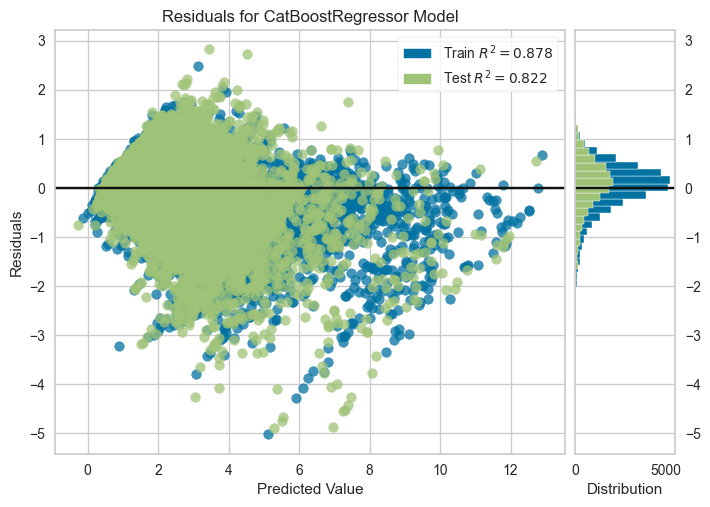

In [50]:
# plot residuals
plot_model(best, plot = 'residuals')

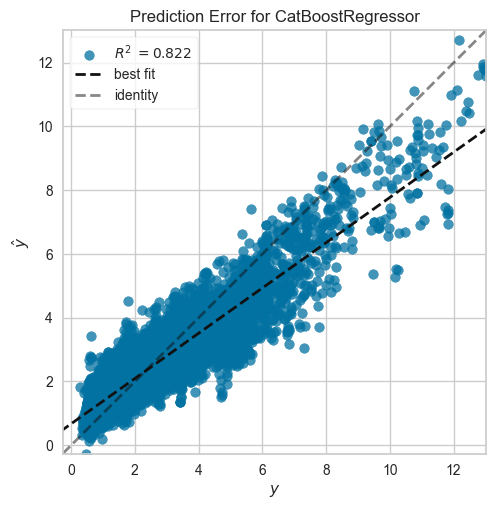

In [51]:
# plot error
plot_model(best, plot = 'error')

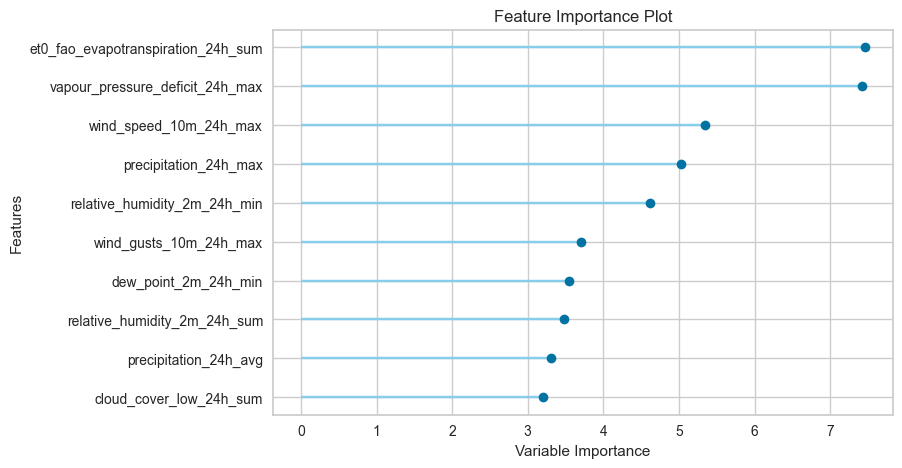

In [52]:
# plot feature importance
plot_model(best, plot = 'feature')

In [53]:
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [54]:
# predict on test set
holdout_pred = predict_model(best)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,0.4713,0.4306,0.6562,0.8219,0.1826,0.2557


In [55]:
# show predictions df
holdout_pred.head()

,temperature_2m,relative_humidity_2m,dew_point_2m,apparent_temperature,precipitation_probability,precipitation,rain,snowfall,showers,snow_depth,...,wind_gusts_10m_lag_13h,wind_gusts_10m_lag_14h,wind_gusts_10m_lag_15h,wind_gusts_10m_lag_16h,wind_gusts_10m_lag_17h,wind_gusts_10m_lag_18h,wind_gusts_10m_lag_19h,wind_gusts_10m_lag_20h,water_level_next_24h,prediction_label
46262,24.000000,87,21.600000,27.200001,NaN,0.1,0.1,0.0,0.0,0.0,...,10.1,13.7,14.400000,15.800000,19.100000,19.400000,17.299999,15.100000,2.42,2.625201
50279,16.299999,76,12.100000,15.400000,NaN,0.0,0.0,0.0,0.0,0.0,...,13.0,15.5,17.299999,16.200001,15.100000,19.799999,26.299999,26.600000,1.67,1.763438
35359,20.900000,100,20.799999,24.799999,NaN,0.1,0.1,0.0,0.0,0.0,...,15.8,8.3,9.000000,13.700000,13.700000,13.300000,6.500000,4.700000,4.46,3.736124
2830,17.400000,91,16.000000,18.299999,NaN,0.0,0.0,0.0,0.0,0.0,...,9.4,23.0,17.299999,21.200001,19.799999,15.800000,11.900000,21.200001,1.71,1.872985
22629,11.800000,96,11.200000,11.100000,NaN,0.0,0.0,0.0,0.0,0.0,...,15.8,14.0,14.400000,15.100000,16.600000,16.200001,14.400000,13.700000,1.07,1.141011


In [57]:
# save pipeline
save_model(best, 'catboost_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['temperature_2m',
                                              'relative_humidity_2m',
                                              'dew_point_2m',
                                              'apparent_temperature',
                                              'precipitation_probability',
                                              'precipitation', 'rain',
                                              'snowfall', 'showers',
                                              'snow_depth', 'weather_code',
                                              'pressure_msl', 'surface_pressure',
                                              'cloud_cover', 'cloud_cover_low',
                                              'cloud_cover...
                                     transformer=VarianceThreshold(threshold=0.1))),
                 ('remove_multicollinearity',
         

In [59]:
predict_df = generate(
    start_date="2025-04-20",
    end_date="2025-04-28",
    type="train",
    save=False
)

2025-05-03 00:43:09.806 | INFO     | data.scraping:__init__:12 - WebScraper inicializado
2025-05-03 00:43:09.808 | INFO     | data.generate_data:__init__:32 - DataGenerator initialized with output directory: /Users/matheus/Documents/projects/Enchentes/data/output
2025-05-03 00:43:09.809 | INFO     | data.generate_data:generate:198 - Generating train dataset from 2025-04-20 to 2025-04-28
2025-05-03 00:43:09.809 | INFO     | data.generate_data:_get_weather_data:45 - Fetching weather data from 2025-04-20 to 2025-04-28
2025-05-03 00:43:11.150 | INFO     | data.generate_data:_get_weather_data:49 - Weather data fetched successfully: (216, 42) rows
2025-05-03 00:43:11.151 | INFO     | data.generate_data:_get_water_level_data:66 - Scraping water level data from 2025-04-20 to 2025-04-28
2025-05-03 00:43:11.151 | INFO     | data.scraping:parse_data:24 - Iniciando análise de dados de 2025-04-20 até 2025-04-28
2025-05-03 00:43:11.157 | INFO     | data.scraping:parse_data:30 - Serão processados 3 i

Processando intervalos:   0%|          | 0/3 [00:00<?, ?it/s]

2025-05-03 00:43:12.183 | INFO     | data.scraping:parse_data:68 - Análise de dados concluída com sucesso
2025-05-03 00:43:12.188 | INFO     | data.scraping:parse_data:80 - Formato final do DataFrame: (147, 2)
2025-05-03 00:43:12.189 | INFO     | data.generate_data:_get_water_level_data:69 - Water level data scraped successfully: (147, 2) rows
2025-05-03 00:43:12.208 | INFO     | data.generate_data:_merge_datasets:107 - Datasets merged successfully: (216, 44) rows


Generating feature engineering features:   0%|          | 0/45 [00:00<?, ?it/s]

2025-05-03 00:43:12.268 | INFO     | data.generate_data:_process_data:173 - Data processing completed: (192, 556) rows


In [61]:
predict_df = predict_model(best, data=predict_df)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,0.5569,0.4577,0.6765,-14.3581,0.2474,0.4239


In [63]:
# Adiciona ao DataFrame
predict_df['predicted_water_level_next_24h'] = predict_df['prediction_label']

# Adiciona intervalo de confiança em 30% de erro
predict_df['predicted_water_level_next_24h_std'] = predict_df['predicted_water_level_next_24h'].std()
predict_df['predicted_water_level_next_24h_lower'] = predict_df['predicted_water_level_next_24h'] - 0.3 * predict_df['predicted_water_level_next_24h_std']
predict_df['predicted_water_level_next_24h_upper'] = predict_df['predicted_water_level_next_24h'] + 0.3 * predict_df['predicted_water_level_next_24h_std']

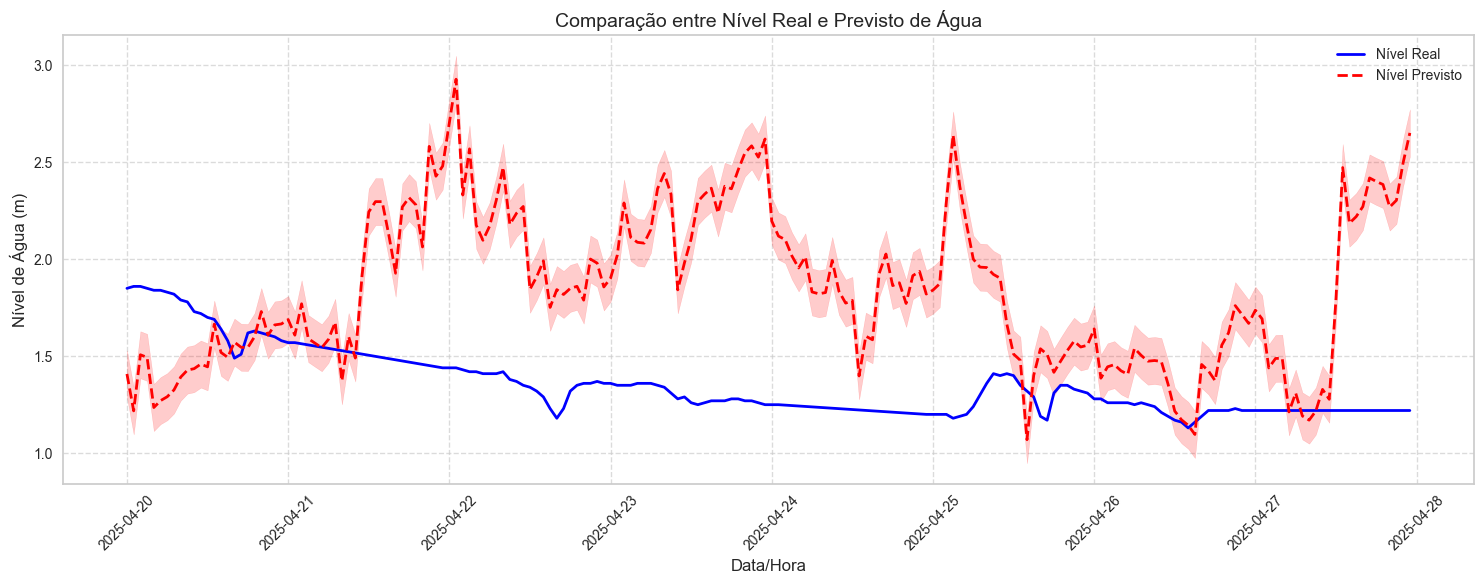

In [64]:
plt.figure(figsize=(15, 6))

# Plotando o nível real
plt.plot(predict_df['time'], predict_df['water_level_next_24h'], 
         label='Nível Real', linewidth=2, color='blue')

# Plotando o nível previsto
plt.plot(predict_df['time'], predict_df['predicted_water_level_next_24h'], 
         label='Nível Previsto', linewidth=2, color='red', linestyle='--')

# Plotando o intervalo de confiança
plt.fill_between(predict_df['time'], 
                 predict_df['predicted_water_level_next_24h_lower'], 
                 predict_df['predicted_water_level_next_24h_upper'], 
                 color='red', alpha=0.2)

# Configurações do gráfico
plt.title('Comparação entre Nível Real e Previsto de Água', fontsize=14)
plt.xlabel('Data/Hora', fontsize=12)
plt.ylabel('Nível de Água (m)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)

plt.xticks(rotation=45)

plt.tight_layout()

plt.show()

In [21]:
# load pipeline
loaded_best_pipeline = load_model('my_best_model')
loaded_best_pipeline

Transformation Pipeline and Model Successfully Loaded


Pipeline(memory=FastMemory(location=/var/folders/gr/gthl841n3w12njgwf034zxh40000gn/T/joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['temperature_2m',
                                             'relative_humidity_2m',
                                             'dew_point_2m',
                                             'apparent_temperature',
                                             'precipitation_probability',
                                             'precipitation', 'rain',
                                             'snowfall', 'showers',
                                             'snow_depth', 'weather_code',
                                             'pressure_msl', 'surface...
                                             'wind_speed_10m', 'wind_speed_80m',
                                             'wind_speed_120m',
                                             'wind_speed_180m',
                                             'wind_direction_10m',
                                             'wind_direction_80m',
                                             'wind_direction_120m',
                                             'wind_gusts_10m',
                                             'wind_direction_180m', ...],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=[],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('trained_model',
                 ExtraTreesRegressor(n_jobs=-1, random_state=42))])

### Modelos básicos de regressão do Scikit-learn e comparação de resultados ###
**Serão testados os seguintes modelos:**

LinearRegression

Ridge

Lasso

Elastic Net

Stochastic Gradient Descent

DecisionTreeRegressor

RandomForestRegressor

SVR

GXBoost

LinearRegression

In [ ]:
features = [column for column in train_df.columns if column not in ['time'] + [f"water_level_next_{h}h" for h in [1, 3, 6, 12, 24]]]
train_df[features].head()


In [15]:
X = train_df[features]
y = train_df[['water_level_next_24h']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.linear_model import LinearRegression
mliearn = LinearRegression()
mliearn.fit(X_train.fillna(0), y_train)
y_pred = mliearn.predict(X_test.fillna(0))
print("Erro médio quadrático (MSE):", mean_squared_error(y_test, y_pred))
print("R² (coeficiente de determinação):", r2_score(y_test, y_pred))

Rigde

In [ ]:
from sklearn.linear_model import Ridge
mridge = Ridge(alpha=1.0)
mridge.fit(X_train.fillna(0), y_train)
y_pred = mridge.predict(X_test.fillna(0))
print("Erro médio quadrático (MSE):", mean_squared_error(y_test, y_pred))
print("R² (coeficiente de determinação):", r2_score(y_test, y_pred))

Lasso

In [ ]:
from sklearn.linear_model import Lasso
mlasso = Lasso(alpha=0.1)
mlasso.fit(X_train.fillna(0), y_train)
y_pred = mlasso.predict(X_test.fillna(0))
print("Erro médio quadrático (MSE):", mean_squared_error(y_test, y_pred))
print("R² (coeficiente de determinação):", r2_score(y_test, y_pred))

Elastic net

In [ ]:
from sklearn.linear_model import ElasticNet
modelo_elastic = ElasticNet(alpha=0.1, l1_ratio=0.5)
modelo_elastic.fit(X_train.fillna(0), y_train)
y_pred = modelo_elastic.predict(X_test.fillna(0))
print("Erro médio quadrático (MSE):", mean_squared_error(y_test, y_pred))
print("R² (coeficiente de determinação):", r2_score(y_test, y_pred))

Stochastic Gradient Descent


In [ ]:
from sklearn.linear_model import SGDRegressor
modelo_sgd = SGDRegressor(
penalty='l2',        # 'l2' = Ridge, 'l1' = Lasso, 'elasticnet' = ambos
alpha=0.001,         # força da regularização
max_iter=1000,       # número máximo de iterações
tol=1e-3,            # tolerância pro critério de parada
random_state=42
)
modelo_sgd.fit(X_train.fillna(0), y_train)
y_pred = modelo_sgd.predict(X_test.fillna(0))
print("Erro médio quadrático (MSE):", mean_squared_error(y_test, y_pred))
print("R² (coeficiente de determinação):", r2_score(y_test, y_pred))

DecisionTreeRegressor


In [ ]:
from sklearn.tree import DecisionTreeRegressor
modelo_arvore = DecisionTreeRegressor(random_state=42, max_depth=5)
modelo_arvore.fit(X_train.fillna(0), y_train)
y_pred = modelo_arvore.predict(X_test.fillna(0))
print("Erro médio quadrático (MSE):", mean_squared_error(y_test, y_pred))
print("R² (coeficiente de determinação):", r2_score(y_test, y_pred))

RandomForestRegressor

In [ ]:
import joblib
from sklearn.ensemble import RandomForestRegressor
modelo_floresta = RandomForestRegressor(random_state=42, n_estimators=100)
modelo_floresta.fit(X_train.fillna(0), y_train)
y_pred = modelo_floresta.predict(X_test.fillna(0))
print("Erro médio quadrático (MSE):", mean_squared_error(y_test, y_pred))
print("R² (coeficiente de determinação):", r2_score(y_test, y_pred))
joblib.dump(modelo_floresta, 'modelo_random_forest.pkl')
print('Modelo salvo como modelo_random_forest.pkl')

SVR

In [ ]:
from sklearn.svm import SVR
modelo_svr = SVR(kernel='rbf')
modelo_svr.fit(X_train.fillna(0), y_train)
y_pred = modelo_svr.predict(X_test.fillna(0))
print("Erro médio quadrático (MSE):", mean_squared_error(y_test, y_pred))
print("R² (coeficiente de determinação):", r2_score(y_test, y_pred))

XGBOOST

In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import json

# Modelo base
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

# Definição do grid de hiperparâmetros
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Busca aleatória
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=100,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Treinamento com os melhores parâmetros
random_search.fit(X_train.fillna(0), y_train)
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test.fillna(0))

# Salvando modelo
best_model.save_model("modelo_salvo1.json")

# Métricas
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Melhores parâmetros encontrados:", random_search.best_params_)
print(f"RMSE no conjunto de teste: {rmse:.2f}")
print("Erro médio quadrático (MSE):", mean_squared_error(y_test, y_pred))
print("R² (coeficiente de determinação):", r2_score(y_test, y_pred))

### Resultado: XGBoost ###

### Previsão e Resultado ###
#### Escolhendo uma data, houve um teste de resultado para saber a proximidade da previsão com o resultado verdadeiro a partir do XGBoost ####

In [ ]:
predict_df = generate(
    start_date="2025-04-20",
    end_date="2025-04-28",
    type="train",
    save=False
)

In [ ]:
import xgboost as xgb

# Carregar o modelo treinado
modelo_xgb = xgb.XGBRegressor()
modelo_xgb.load_model('modelo_salvo1.json')

# Adiciona ao DataFrame
predict_df['predicted_water_level_next_24h'] = modelo_xgb.predict(predict_df[features].fillna(0))

# Adiciona intervalo de confiança em 30% de erro
predict_df['predicted_water_level_next_24h_std'] = predict_df['predicted_water_level_next_24h'].std()
predict_df['predicted_water_level_next_24h_lower'] = predict_df['predicted_water_level_next_24h'] - 0.3 * predict_df['predicted_water_level_next_24h_std']
predict_df['predicted_water_level_next_24h_upper'] = predict_df['predicted_water_level_next_24h'] + 0.3 * predict_df['predicted_water_level_next_24h_std']

# Exibe
predict_df[['time','predicted_water_level_next_24h_lower','predicted_water_level_next_24h', 'predicted_water_level_next_24h_upper']]

In [ ]:
plt.figure(figsize=(15, 6))

# Plotando o nível real
plt.plot(predict_df['time'], predict_df['water_level_next_24h'], 
         label='Nível Real', linewidth=2, color='blue')

# Plotando o nível previsto
plt.plot(predict_df['time'], predict_df['predicted_water_level_next_24h'], 
         label='Nível Previsto', linewidth=2, color='red', linestyle='--')

# Plotando o intervalo de confiança
plt.fill_between(predict_df['time'], 
                 predict_df['predicted_water_level_next_24h_lower'], 
                 predict_df['predicted_water_level_next_24h_upper'], 
                 color='red', alpha=0.2)

# Configurações do gráfico
plt.title('Comparação entre Nível Real e Previsto de Água', fontsize=14)
plt.xlabel('Data/Hora', fontsize=12)
plt.ylabel('Nível de Água (m)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)

plt.xticks(rotation=45)

plt.tight_layout()

plt.show()